# Preparation

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Base df
df = pd.read_csv('data/z_df_ready_for_analysis.csv')

In [29]:
# df exluding year outliers

# Step 1: Compute Q1, Q3, and IQR
Q1 = df['year'].quantile(0.25)
Q3 = df['year'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter the outlier rows
outlier_years = df[(df['year'] < lower_bound) | (df['year'] > upper_bound)]['year'].unique()

# Step 4: Keep only rows where 'year' is NOT an outlier
df_no_o = df[(df['year'] >= lower_bound) & (df['year'] <= upper_bound)].copy()

In [ ]:
# Make sure gender is a categorical variable with the desired order for plotting
# Base df
df['author_gender'] = pd.Categorical(
    df['author_gender'].replace({0: 'Male', 1: 'Female'}),
    categories=['Male', 'Female'],
    ordered=True
)

# No outliers df
df_no_o['author_gender'] = pd.Categorical(
    df_no_o['author_gender'].replace({0: 'Male', 1: 'Female'}),
    categories=['Male', 'Female'],
    ordered=True
)

# Check Assumptions for MLR
## Linearity

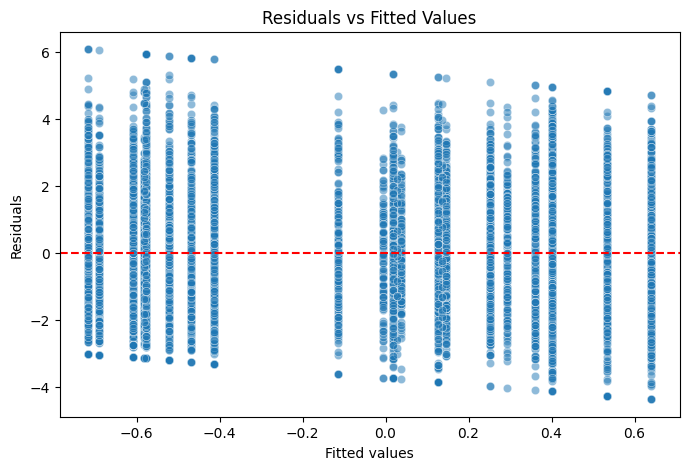

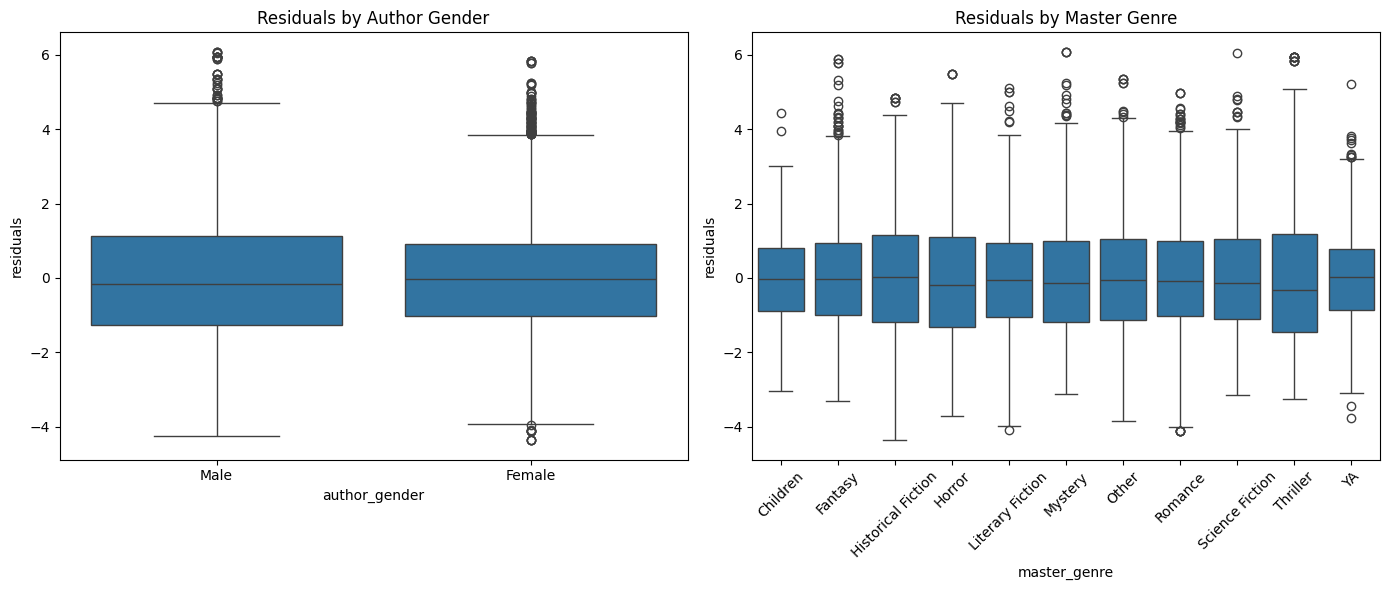

In [ ]:
# Fit model
model = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()

# Get residuals and fitted values
df['residuals'] = model.resid
df['fitted'] = model.fittedvalues

# 1. Residuals vs Fitted values plot (should be random scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 2. Residuals by category plots

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='author_gender', y='residuals', data=df)
plt.title('Residuals by Author Gender')

plt.subplot(1, 2, 2)
sns.boxplot(x='master_genre', y='residuals', data=df)
plt.title('Residuals by Master Genre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


* Residuals vs Fitted plot: No pattern (no curve or funnel shape) means good linearity.
* Boxplots of residuals by category: Medians should be near zero and roughly similar spreads.

## Independence of errors

In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat:.3f}')


Durbin-Watson statistic: 1.945


Around 2.0 → Residuals are independent (ideal)  
Closer to 0 → Positive autocorrelation (bad)  
Closer to 4 → Negative autocorrelation (also bad)  

## Homoscedasticity
* see Residuals vs. Fitted Values plot

## Mulitcollinearity

In [90]:
X = model.model.exog  # gets the design matrix
feature_names = model.model.exog_names

vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)


                                  feature        VIF
0                               Intercept  49.206397
1              C(author_gender)[T.Female]   1.164747
2              C(master_genre)[T.Fantasy]   6.843944
3   C(master_genre)[T.Historical Fiction]   5.049184
4               C(master_genre)[T.Horror]   2.098190
5     C(master_genre)[T.Literary Fiction]   5.087584
6              C(master_genre)[T.Mystery]   4.778303
7                C(master_genre)[T.Other]   4.423931
8              C(master_genre)[T.Romance]   8.688538
9      C(master_genre)[T.Science Fiction]   3.187410
10            C(master_genre)[T.Thriller]   3.848429
11                  C(master_genre)[T.YA]   4.073848


# Descriptives
## Standardized Means 
### General

In [8]:
df[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

,z_prop_pos,z_prop_neg,z_diff_prop
count,1.386900e+04,1.386900e+04,1.386900e+04
mean,1.352536e-16,-8.402120e-17,2.213241e-16
std,1.000036e+00,1.000036e+00,1.632462e+00
min,-1.733324e+00,-2.002652e+00,-3.726654e+00
25%,-7.145819e-01,-7.731193e-01,-1.150515e+00
50%,-3.542010e-02,-4.661141e-03,-3.407555e-02
75%,6.176201e-01,7.637970e-01,1.045082e+00
max,3.360389e+00,1.993330e+00,5.363041e+00


In [32]:
df_no_o[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

,z_prop_pos,z_prop_neg,z_diff_prop
count,12631.000000,12631.000000,12631.000000
mean,0.000967,0.043561,-0.042594
std,1.003642,1.001777,1.636969
min,-1.733324,-2.002652,-3.726654
25%,-0.714582,-0.773119,-1.183148
50%,-0.035420,0.149030,-0.092116
75%,0.617620,0.763797,0.998915
max,3.360389,1.993330,5.363041


### by Author Gender

In [34]:
df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/1455878219.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()


z_prop_pos                                                    \
                   count      mean       std       min       25%       50%   
author_gender                                                                
Male              4204.0 -0.136796  1.061596 -1.733324 -0.949676 -0.166028   
Female            9665.0  0.059502  0.966073 -1.733324 -0.557852 -0.035420   

                                 z_prop_neg            ...                     \
                   75%       max      count      mean  ...       75%      max   
author_gender                                          ...                      
Male           0.61762  3.360389     4204.0  0.057562  ...  0.994334  1.99333   
Female         0.61762  3.360389     9665.0 -0.025038  ...  0.661336  1.99333   

              z_diff_prop                                                    \
                    count      mean       std       min       25%       50%   
author_gender                                                                 
Male               4204.0 -0.194359  1.808203 -3.726654 -1.490531 -0.315059   
Female             9665.0  0.084540  1.542287 -3.726654 -0.989507  0.054758   

                                   
                    75%       max  
author_gender                      
Male           0.998915  5.363041  
Female         1.080116  5.363041  

[2 rows x 24 columns]

In [35]:
df_no_o.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/845911213.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_no_o.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()


z_prop_pos                                                    \
                   count      mean       std       min       25%       50%   
author_gender                                                                
Male              3484.0 -0.173552  1.068145 -1.733324 -0.949676 -0.166028   
Female            9147.0  0.067439  0.969791 -1.733324 -0.557852 -0.035420   

                                 z_prop_neg            ...                     \
                   75%       max      count      mean  ...       75%      max   
author_gender                                          ...                      
Male           0.58200  3.360389     3484.0  0.170040  ...  1.071180  1.99333   
Female         0.61762  3.360389     9147.0 -0.004614  ...  0.763797  1.99333   

              z_diff_prop                                                    \
                    count      mean       std       min       25%       50%   
author_gender                                                                 
Male               3484.0 -0.343592  1.809531 -3.726654 -1.631071 -0.491834   
Female             9147.0  0.072053  1.551068 -3.726654 -1.014266  0.022705   

                                   
                    75%       max  
author_gender                      
Male           0.798446  5.363041  
Female         1.049726  5.363041  

[2 rows x 24 columns]

# Regressions

## Total (Difference in Standardized Proportions)
### Year Outliers Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_diff_prop ~ author_gender + master_genre', data=df).fit()
print(model.summary())

In [ ]:
# Regression Coefficients with interaction and year
model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (negative)

In [75]:
# ANOVA for easier reporting of categorical predictor results
# Without interaction -> ag and g significant
model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F         PR(>F)
Intercept             0.232817      1.0    0.094256   7.588396e-01
C(author_gender)     29.322407      1.0   11.871137   5.717952e-04
C(master_genre)    2501.783718     10.0  101.284376  1.120967e-203
Residual          34227.605747  13857.0         NaN            NaN


In [ ]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df,
    dv='z_diff_prop',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.000860 -> not even small
# Effect size genre: 0.068436 -> medium
# Effect size author gender*genre: 0.005042 -> small

                         Source            SS       DF          MS  \
0                 author_gender     29.322407      1.0   29.322407   
1                  master_genre   2501.783718     10.0  250.178372   
2  author_gender * master_genre    172.580206     10.0   17.258021   
3                      Residual  34055.025541  13847.0    2.459379   

            F          p-unc       np2  
0   11.922686   5.562023e-04  0.000860  
1  101.724191  1.485835e-204  0.068436  
2    7.017226   4.403798e-11  0.005042  
3         NaN            NaN       NaN  


In [ ]:
# ANOVA for easier reporting of categorical predictor results
# With interaction -> ag*g significant
model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             4.721091      1.0   1.919627   
C(author_gender)                     11.207324      1.0   4.556972   
C(master_genre)                    1012.999142     10.0  41.189219   
C(author_gender):C(master_genre)    172.580206     10.0   7.017226   
Residual                          34055.025541  13847.0        NaN   

                                        PR(>F)  
Intercept                         1.659201e-01  
C(author_gender)                  3.280249e-02  
C(master_genre)                   4.968027e-81  
C(author_gender):C(master_genre)  4.403798e-11  
Residual                                   NaN  


### Year Outliers NOT Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (negative) (but less)

In [91]:
# Without interaction -> ag and g still significant
model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            12.123820      1.0   4.900397   2.686833e-02
C(author_gender)     92.991200      1.0  37.586651   9.005012e-10
C(master_genre)    2188.287958     10.0  88.449678  2.855424e-177
Residual          31220.018489  12619.0        NaN            NaN


In [ ]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_no_o,
    dv='z_diff_prop',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.002987 -> not even small
# Effect size genre: 0.065851 -> medium
# Effect size author gender*genre: 0.005690 -> small
# Effect sizes are the same with and without outliers

                         Source            SS       DF          MS          F  \
0                 author_gender     92.991200      1.0   92.991200  37.771769   
1                  master_genre   2188.287958     10.0  218.828796  88.885300   
2  author_gender * master_genre    177.626852     10.0   17.762685   7.214963   
3                      Residual  31042.391637  12609.0    2.461923        NaN   

           p-unc       np2  
0   8.192248e-10  0.002987  
1  3.842548e-178  0.065851  
2   1.846697e-11  0.005690  
3            NaN       NaN  


In [ ]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             7.260051      1.0   2.948934   
C(author_gender)                      5.632129      1.0   2.287695   
C(master_genre)                     772.488173     10.0  31.377426   
C(author_gender):C(master_genre)    177.626852     10.0   7.214963   
Residual                          31042.391637  12609.0        NaN   

                                        PR(>F)  
Intercept                         8.595875e-02  
C(author_gender)                  1.304285e-01  
C(master_genre)                   1.174943e-60  
C(author_gender):C(master_genre)  1.846697e-11  
Residual                                   NaN  


### Plots (with outliers only)

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/2023288478.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='author_gender', y='z_diff_prop', palette='pastel', errorbar=('ci', 95))


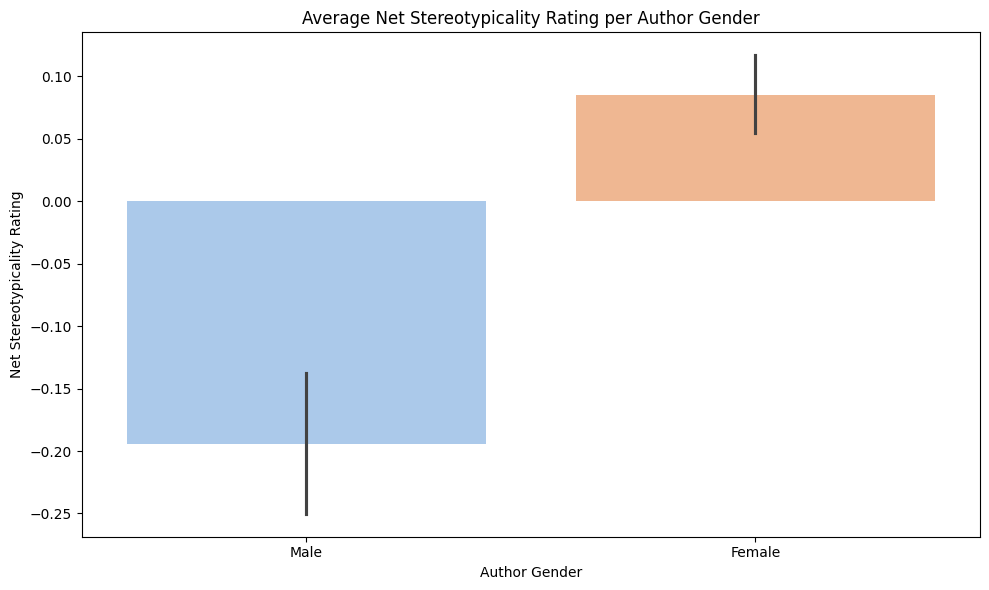

In [22]:
# Author Gender ME - Total - Plot
# Significance: C(author_gender)     29.322407      1.0   11.871137   5.717952e-04

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='author_gender', y='z_diff_prop', palette='pastel', errorbar=('ci', 95))

plt.title("Average Net Stereotypicality Rating per Author Gender")
plt.ylabel("Net Stereotypicality Rating")
plt.xlabel("Author Gender")
plt.tight_layout()
plt.show()

In [ ]:
# Author Gender ME - Total - Significance Test
tukey = pairwise_tukeyhsd(endog=df['z_diff_prop'],
                          groups=df['author_gender'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
Female   Male  -0.2789   0.0 -0.3378 -0.22   True
-------------------------------------------------


In [ ]:
# Author Gender ME - Total - Effect size

# Subset the groups
group_male = df[df['author_gender'] == "Male"]['z_diff_prop']
group_female = df[df['author_gender'] == "Female"]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female, group_male, eftype='cohen', paired=False)

print("Cohen's d:", d)


Cohen's d: 0.1713685941208073


/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/1748057644.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('master_genre')['z_diff_prop'].agg(['mean', 'count', 'std']).reset_index()
/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/1748057644.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df,


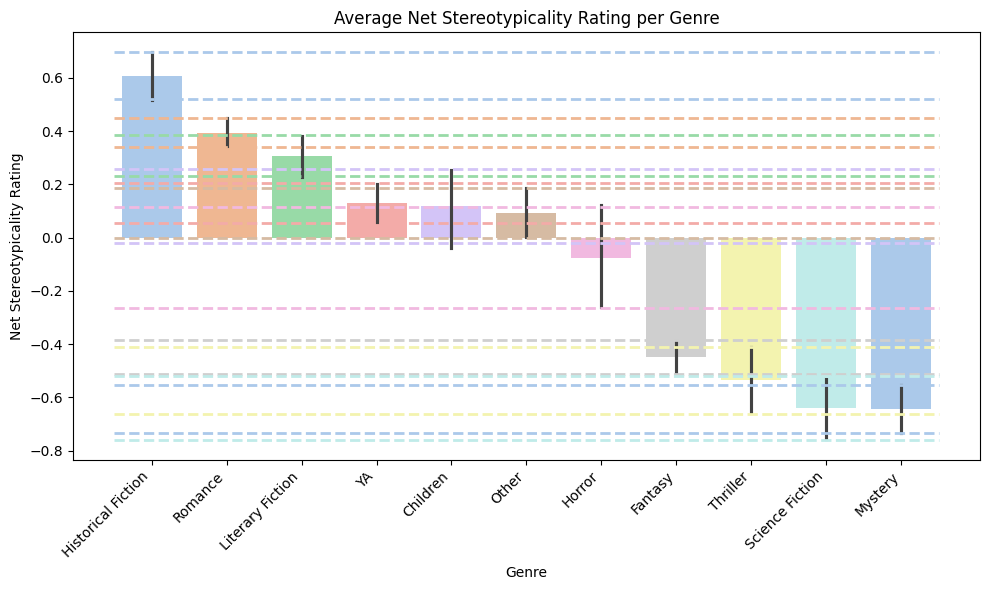

In [ ]:
# Genre ME - Total - Plot

# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_diff_prop'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df, 
                      x='master_genre', 
                      y='z_diff_prop', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Net Stereotypicality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Net Stereotypicality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Total - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_diff_prop']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.5666    0.0 -0.8762  -0.257   True
          Children Historical Fiction   0.4905    0.0  0.1708  0.8102   True
          Children             Horror  -0.1931 0.8992 -0.5917  0.2056  False
          Children   Literary Fiction   0.1906  0.705 -0.1291  0.5102  False
          Children            Mystery  -0.7613    0.0 -1.0833 -0.4393   True
          Children              Other  -0.0261    1.0 -0.3516  0.2995  False
          Children            Romance   0.2759 0.1154 -0.0278  0.5796  False
          Children    Science Fiction  -0.7588    0.0 -1.1054 -0.4121   True
          Children           Thriller  -0.6535    0.0 -0.9875 -0.3196   True
          Children                 YA   0.0111    1.0 -0.3186  0.3407  False

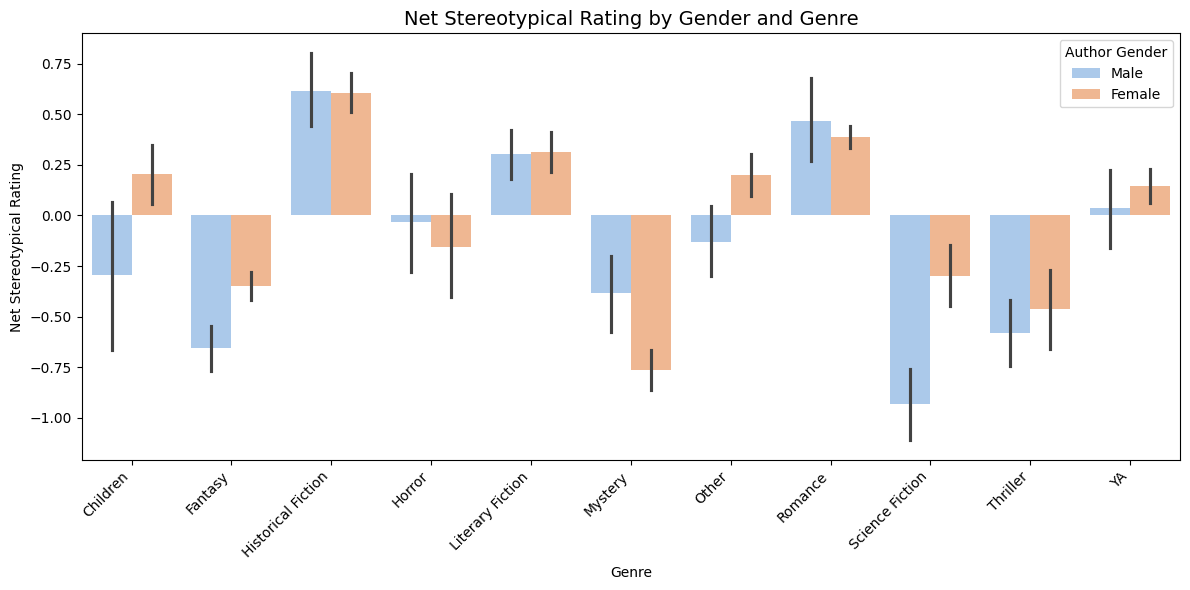

In [25]:
# Interaction - Total - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='master_genre',
    y='z_diff_prop',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Net Stereotypical Rating by Gender and Genre", fontsize=14)
plt.ylabel("Net Stereotypical Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [26]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Total - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_diff_prop']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy  -0.5565    0.0 -0.9417 -0.1713   True
          Female_Children Female_Historical Fiction   0.3981 0.0509 -0.0006  0.7968  False
          Female_Children             Female_Horror  -0.3642   0.89  -0.988  0.2595  False
          Female_Children   Female_Literary Fiction   0.1068    1.0 -0.3048  0.5183  False
          Female_Children            Female_Mystery  -0.9715    0.0 -1.3744 -0.5686   True
          Female_Children              Female_Other  -0.0078    1.0 -0.4163  0.4006  False
          Female_Children            Female_Romance   0.1816 0.9808 -0.1892  0.5525  False
          Female_Children    Female_Science Fiction  -0.5039 0.0227 -0.9778 -0.0301   True

In [ ]:
# Author Gender * Genre - Total - Effect size - Fantasy

# Subset the groups
group_female_fantasy = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Fantasy")]['z_diff_prop']
group_male_fantasy = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Fantasy")]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_fantasy, group_male_fantasy, eftype='cohen', paired=False)

print("Cohen's d for Female vs Male Fantasy:", d)

Cohen's d for Female vs Male Fantasy: 0.20428068176176006


In [99]:
# Author Gender * Genre - Total - Effect size - Science Fiction

# Subset the groups
group_female_scifi = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']
group_male_scifi = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_scifi, group_male_scifi, eftype='cohen', paired=False)

print("Cohen's d for Female vs Male Science Fiction:", d)

Cohen's d for Female vs Male Science Fiction: 0.39596323341354894


## Standardized Pro-Stereotypical Items
### Year Outliers Included

In [41]:
# Regression Coefficients 
model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (negative)

                            OLS Regression Results                            
Dep. Variable:             z_prop_pos   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     38.37
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          3.31e-159
Time:                        21:46:42   Log-Likelihood:                -19269.
No. Observations:               13869   AIC:                         3.858e+04
Df Residuals:                   13846   BIC:                         3.876e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [42]:
# Without interaction -> ag and g significant
model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            74.849729      1.0  78.576149   8.624914e-19
C(author_gender)     45.844220      1.0  48.126590   4.172978e-12
C(master_genre)     556.268960     10.0  58.396300  1.619220e-116
Residual          13199.841379  13857.0        NaN            NaN


In [43]:
# With interaction -> ag*g significant
model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                            22.901505      1.0  24.175169   
C(author_gender)                      4.003445      1.0   4.226096   
C(master_genre)                     141.281194     10.0  14.913853   
C(author_gender):C(master_genre)     82.367637     10.0   8.694850   
Residual                          13117.473742  13847.0        NaN   

                                        PR(>F)  
Intercept                         8.896740e-07  
C(author_gender)                  3.982561e-02  
C(master_genre)                   8.012838e-27  
C(author_gender):C(master_genre)  2.408406e-14  
Residual                                   NaN  


### Year Outliers NOT Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (negative) (but stronger)

                            OLS Regression Results                            
Dep. Variable:             z_prop_pos   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     35.34
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          1.90e-145
Time:                        21:48:10   Log-Likelihood:                -17590.
No. Observations:               12631   AIC:                         3.523e+04
Df Residuals:                   12608   BIC:                         3.540e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [45]:
# Without interaction -> ag and g still significant
model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            85.613578      1.0  89.407717   3.774549e-21
C(author_gender)     64.582396      1.0  67.444495   2.376910e-16
C(master_genre)     492.143316     10.0  51.395364  6.407905e-102
Residual          12083.495542  12619.0        NaN            NaN


In [46]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                            22.385091      1.0  23.527710   
C(author_gender)                      1.802653      1.0   1.894668   
C(master_genre)                     108.412904     10.0  11.394671   
C(author_gender):C(master_genre)     86.849580     10.0   9.128271   
Residual                          11996.645962  12609.0        NaN   

                                        PR(>F)  
Intercept                         1.245990e-06  
C(author_gender)                  1.687009e-01  
C(master_genre)                   1.062845e-19  
C(author_gender):C(master_genre)  3.418789e-15  
Residual                                   NaN  


### Plots (all with outliers)

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/963963328.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='author_gender', y='z_prop_pos', palette='pastel', errorbar=('ci', 95))


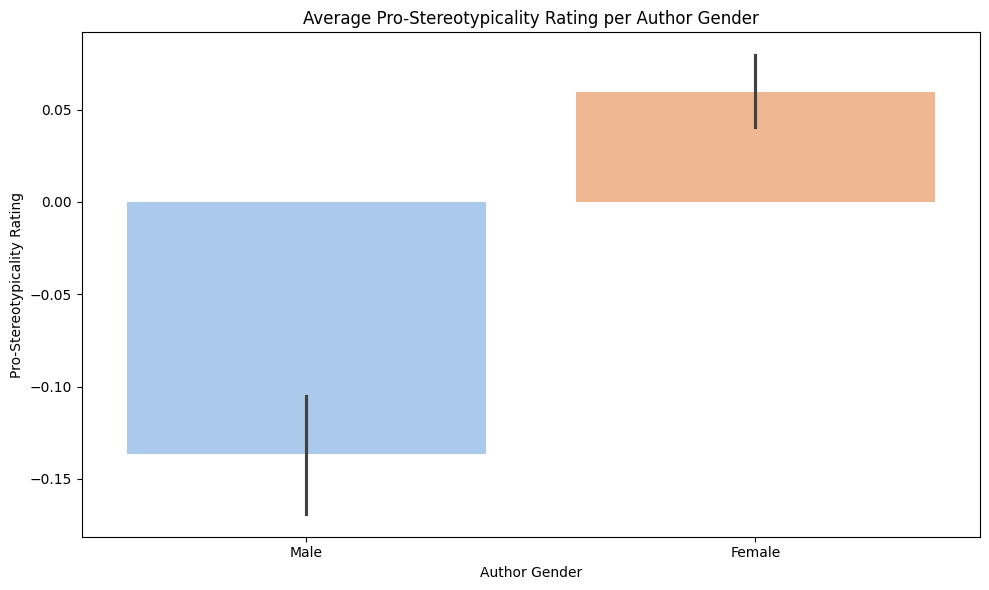

In [47]:
# Author Gender ME - Pos - Plot
# Significance: C(author_gender)     45.844220      1.0  48.126590   4.172978e-12

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='author_gender', y='z_prop_pos', palette='pastel', errorbar=('ci', 95))

plt.title("Average Pro-Stereotypicality Rating per Author Gender")
plt.ylabel("Pro-Stereotypicality Rating")
plt.xlabel("Author Gender")
plt.tight_layout()
plt.show()

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/2552036923.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('master_genre')['z_prop_pos'].agg(['mean', 'count', 'std']).reset_index()
/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/2552036923.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df,


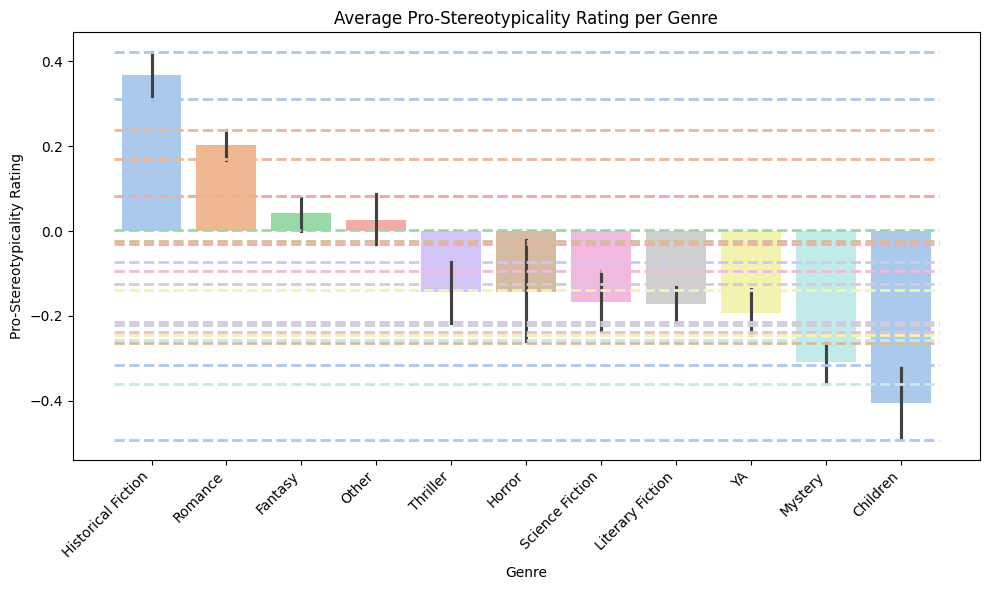

In [48]:
# Genre ME - Pos - Plot

# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_prop_pos'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df, 
                      x='master_genre', 
                      y='z_prop_pos', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Pro-Stereotypicality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Pro-Stereotypicality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [49]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Pos - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_prop_pos']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy   0.4464    0.0  0.2538  0.6389   True
          Children Historical Fiction   0.7711    0.0  0.5723  0.9699   True
          Children             Horror   0.2603 0.0301  0.0124  0.5081   True
          Children   Literary Fiction   0.2311 0.0084  0.0323  0.4299   True
          Children            Mystery   0.0945 0.9137 -0.1057  0.2947  False
          Children              Other   0.4306    0.0  0.2282   0.633   True
          Children            Romance   0.6077    0.0  0.4189  0.7966   True
          Children    Science Fiction   0.2381 0.0166  0.0225  0.4536   True
          Children           Thriller   0.2605 0.0027  0.0528  0.4681   True
          Children                 YA   0.2122 0.0351  0.0072  0.4172   True

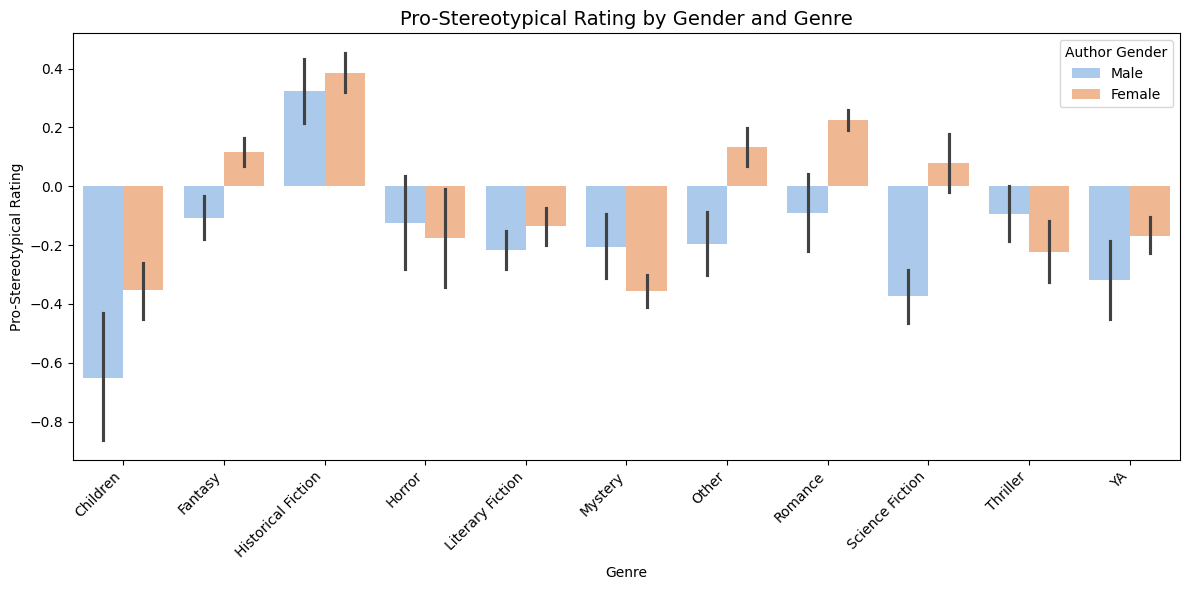

In [50]:
# Interaction - Pos - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='master_genre',
    y='z_prop_pos',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Pro-Stereotypical Rating by Gender and Genre", fontsize=14)
plt.ylabel("Pro-Stereotypical Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [51]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Pos - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_prop_pos']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/svenjakratzke/Desktop/Thesis/thesis/venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy   0.4665    0.0  0.2274  0.7055   True
          Female_Children Female_Historical Fiction   0.7366    0.0  0.4892  0.9841   True
          Female_Children             Female_Horror   0.1744 0.9929 -0.2127  0.5615  False
          Female_Children   Female_Literary Fiction   0.2157 0.2427 -0.0397  0.4711  False
          Female_Children            Female_Mystery  -0.0064    1.0 -0.2565  0.2436  False
          Female_Children              Female_Other   0.4846    0.0  0.2311  0.7381   True
          Female_Children            Female_Romance   0.5764    0.0  0.3462  0.8065   True
          Female_Children    Female_Science Fiction   0.4298    0.0  0.1357  0.7239   True

## Standardized Anti-Stereotypical Items
### Year Outliers Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (pos)

                            OLS Regression Results                            
Dep. Variable:             z_prop_neg   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     97.03
Date:                Wed, 04 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:56:21   Log-Likelihood:                -18685.
No. Observations:               13869   AIC:                         3.742e+04
Df Residuals:                   13846   BIC:                         3.759e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag not significant, g significant
model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F        PR(>F)
Intercept            83.431512      1.0   94.906435  2.354448e-22
C(author_gender)      1.838246      1.0    2.091072  1.481846e-01
C(master_genre)    1667.430027     10.0  189.676341  0.000000e+00
Residual          12181.581389  13857.0         NaN           NaN


In [54]:
# With interaction -> ag*g significant
model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             6.826434      1.0   7.806111   
C(author_gender)                      1.814067      1.0   2.074408   
C(master_genre)                     777.140739     10.0  88.866997   
C(author_gender):C(master_genre)     72.397853     10.0   8.278783   
Residual                          12109.183535  13847.0        NaN   

                                         PR(>F)  
Intercept                          5.214140e-03  
C(author_gender)                   1.498107e-01  
C(master_genre)                   1.186714e-178  
C(author_gender):C(master_genre)   1.574489e-13  
Residual                                    NaN  


### Year Outliers NOT Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (positive) (but more)

                            OLS Regression Results                            
Dep. Variable:             z_prop_neg   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     87.63
Date:                Wed, 04 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:57:50   Log-Likelihood:                -17046.
No. Observations:               12631   AIC:                         3.414e+04
Df Residuals:                   12608   BIC:                         3.431e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag still not significant, g still significant
model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F        PR(>F)
Intercept            33.302512      1.0   37.856057  7.846658e-10
C(author_gender)      2.582054      1.0    2.935106  8.669756e-02
C(master_genre)    1496.860109     10.0  170.152994  0.000000e+00
Residual          11101.113900  12619.0         NaN           NaN


In [57]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             4.148719      1.0   4.744191   
C(author_gender)                      1.062098      1.0   1.214543   
C(master_genre)                     653.503311     10.0  74.730171   
C(author_gender):C(master_genre)     74.746444     10.0   8.547492   
Residual                          11026.367456  12609.0        NaN   

                                         PR(>F)  
Intercept                          2.941584e-02  
C(author_gender)                   2.704553e-01  
C(master_genre)                   1.470026e-149  
C(author_gender):C(master_genre)   4.737335e-14  
Residual                                    NaN  


### Plots (all with outliers)

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/2822996578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='author_gender', y='z_prop_neg', palette='pastel', errorbar=('ci', 90))


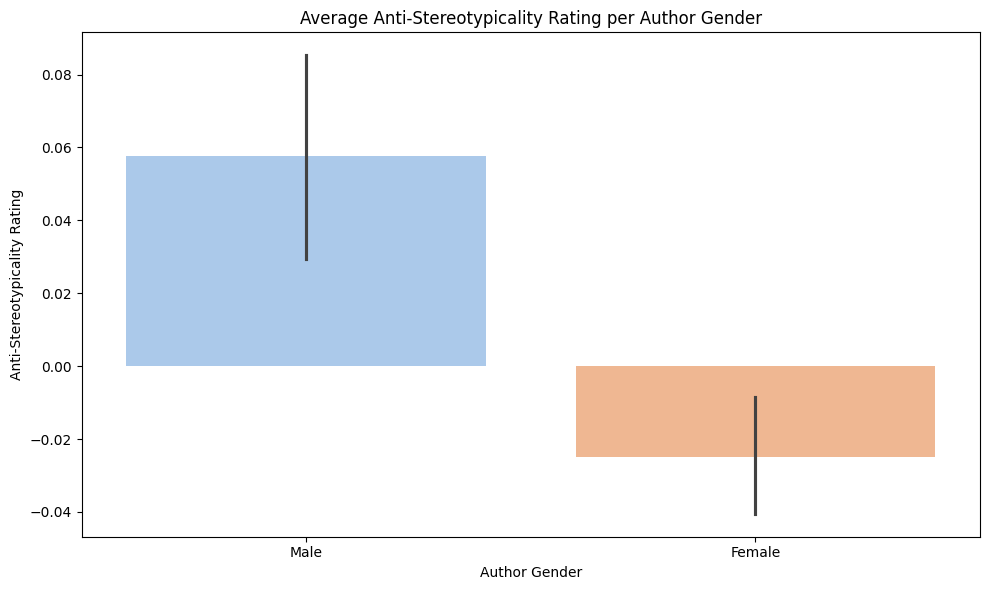

In [ ]:
# Author Gender ME - Neg - Plot
# Significance: C(author_gender)      1.838246      1.0    2.091072  1.481846e-01
# -> (NOT) significant

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='author_gender', y='z_prop_neg', palette='pastel', errorbar=('ci', 90))

plt.title("Average Anti-Stereotypicality Rating per Author Gender")
plt.ylabel("Anti-Stereotypicality Rating")
plt.xlabel("Author Gender")
plt.tight_layout()
plt.show()

/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/3797682273.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('master_genre')['z_prop_neg'].agg(['mean', 'count', 'std']).reset_index()
/var/folders/bx/rdryvfkd49jg3gxyh8cb60s40000gn/T/ipykernel_23502/3797682273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df,


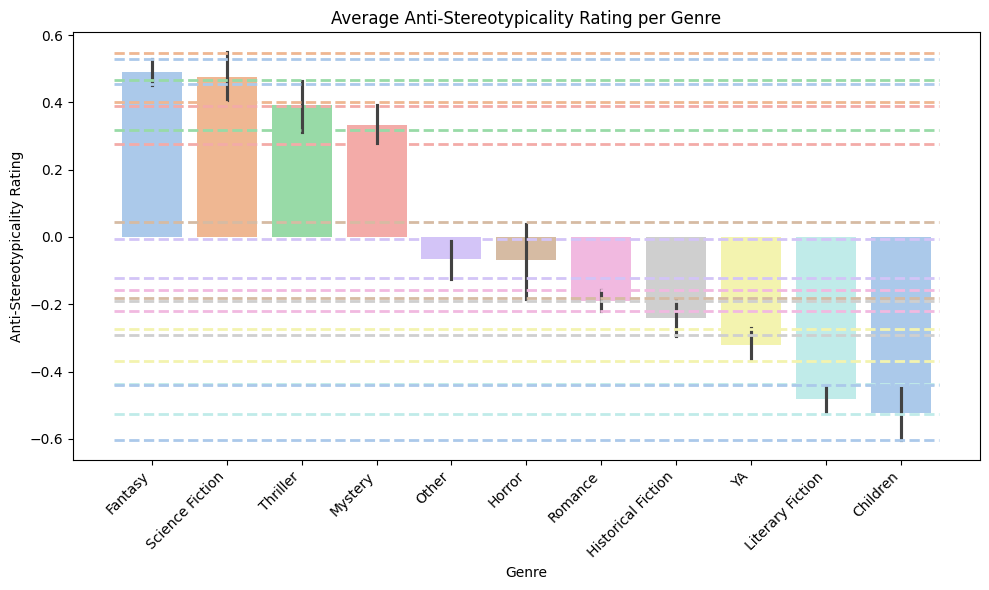

In [62]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_prop_neg'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df, 
                      x='master_genre', 
                      y='z_prop_neg', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Anti-Stereotypicality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Anti-Stereotypicality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [63]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Neg - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_prop_neg']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_neg'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy    1.013    0.0  0.8284  1.1976   True
          Children Historical Fiction   0.2806 0.0001    0.09  0.4713   True
          Children             Horror   0.4533    0.0  0.2156   0.691   True
          Children   Literary Fiction   0.0406 0.9998 -0.1501  0.2312  False
          Children            Mystery   0.8558    0.0  0.6638  1.0478   True
          Children              Other   0.4567    0.0  0.2625  0.6508   True
          Children            Romance   0.3318    0.0  0.1507   0.513   True
          Children    Science Fiction   0.9968    0.0  0.7901  1.2036   True
          Children           Thriller    0.914    0.0  0.7149  1.1132   True
          Children                 YA   0.2011 0.0397  0.0045  0.3977   True

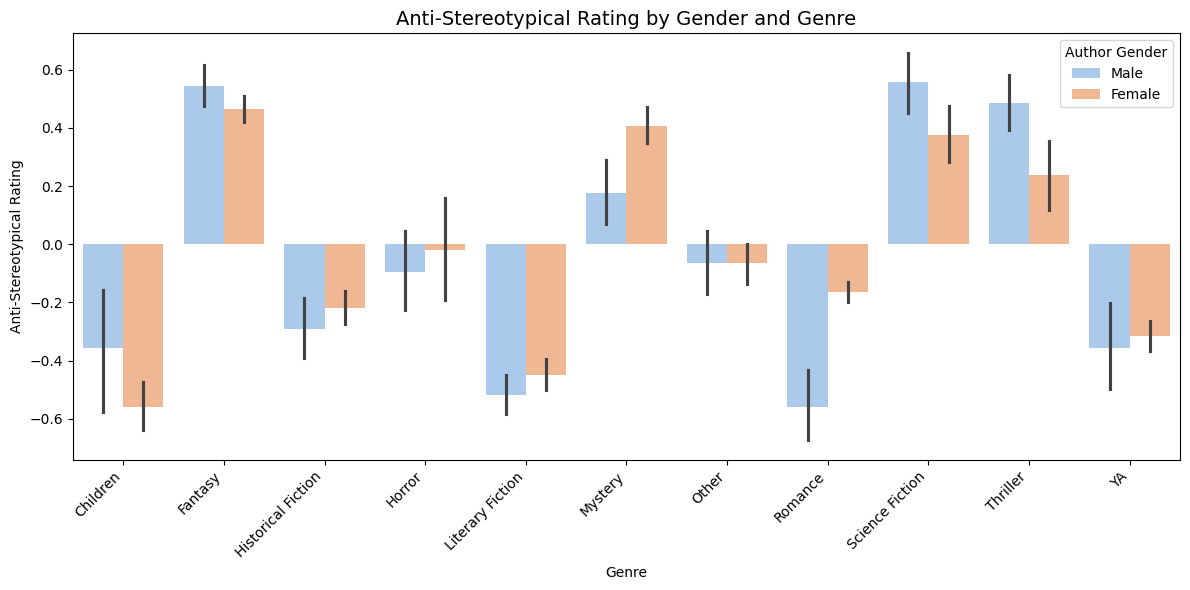

In [64]:
# Interaction - Neg - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='master_genre',
    y='z_prop_neg',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Anti-Stereotypical Rating by Gender and Genre", fontsize=14)
plt.ylabel("Anti-Stereotypical Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [65]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Total - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_diff_prop']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy  -0.5565    0.0 -0.9417 -0.1713   True
          Female_Children Female_Historical Fiction   0.3981 0.0509 -0.0006  0.7968  False
          Female_Children             Female_Horror  -0.3642   0.89  -0.988  0.2595  False
          Female_Children   Female_Literary Fiction   0.1068    1.0 -0.3048  0.5183  False
          Female_Children            Female_Mystery  -0.9715    0.0 -1.3744 -0.5686   True
          Female_Children              Female_Other  -0.0078    1.0 -0.4163  0.4006  False
          Female_Children            Female_Romance   0.1816 0.9808 -0.1892  0.5525  False
          Female_Children    Female_Science Fiction  -0.5039 0.0227 -0.9778 -0.0301   True